<a href="https://colab.research.google.com/github/sayandeepmaity/vseven_lumi/blob/main/hybrid_lstm_cst_gunshot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Class Weights: {np.int64(0): np.float64(5.15035799522673), np.int64(1): np.float64(0.5537593020272004)}
Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9009 - loss: 0.3257 - val_accuracy: 0.9898 - val_loss: 0.0447
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9848 - loss: 0.0578 - val_accuracy: 0.9944 - val_loss: 0.0270
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9969 - loss: 0.0280 - val_accuracy: 0.9778 - val_loss: 0.0679
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9901 - loss: 0.0277 - val_accuracy: 0.9954 - val_loss: 0.0235
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9972 - loss: 0.0151 - val_accuracy: 0.9944 - val_loss: 0.0187
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9974 - loss: 0.0159 - val_accuracy: 0.9972 - val_loss: 0.0

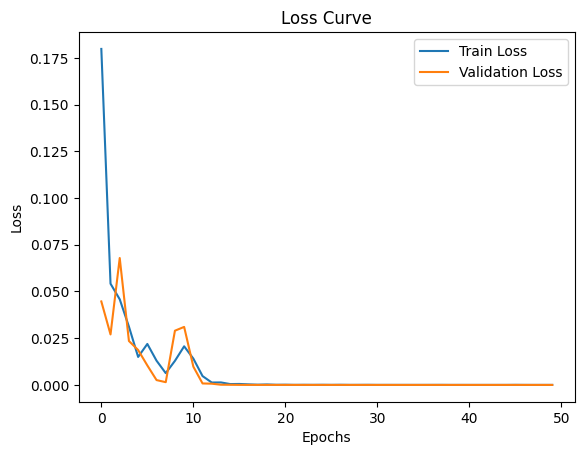

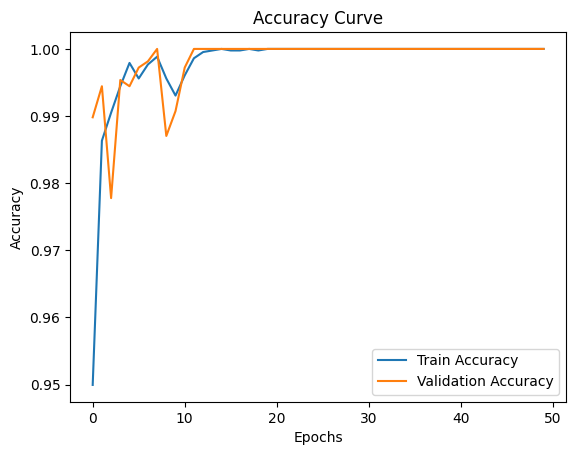

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


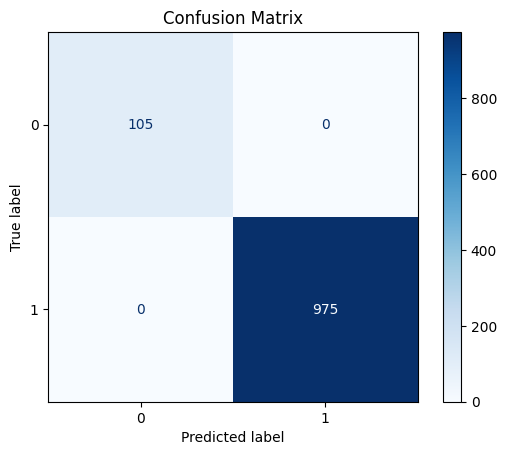

Classification Report:

              precision    recall  f1-score   support

 Non-Gunshot       1.00      1.00      1.00       105
     Gunshot       1.00      1.00      1.00       975

    accuracy                           1.00      1080
   macro avg       1.00      1.00      1.00      1080
weighted avg       1.00      1.00      1.00      1080

Model saved successfully!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D, LSTM
from tensorflow.keras.layers import MultiHeadAttention, Add
from tensorflow.keras.callbacks import EarlyStopping


gunshot_data = pd.read_csv('/content/drive/MyDrive/sevenlumi_data/data_to_fed/cleaned_features.csv')
non_gunshot_data = pd.read_csv('/content/drive/MyDrive/sevenlumi_data/data_to_fed/cleaned_non_gunshot_features.csv')


drop_columns = ['Gun_Type', 'Distance', 'X', 'Y', 'Z', 'Mic', 'Arrival_Time_Difference']
gunshot_data = gunshot_data.drop(columns=drop_columns)
non_gunshot_data = non_gunshot_data.drop(columns=drop_columns)


data = pd.concat([gunshot_data, non_gunshot_data], ignore_index=True)


X = data.drop(columns=['Gunshot'])
y = data['Gunshot']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Class Weights:", class_weight_dict)




input_layer = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))


lstm_out = LSTM(64, return_sequences=True)(input_layer)


attention_out = MultiHeadAttention(num_heads=4, key_dim=16)(lstm_out, lstm_out)
attention_out = Dropout(0.3)(attention_out)
attention_out = LayerNormalization(epsilon=1e-6)(attention_out + lstm_out)


ffn = Dense(64, activation='relu')(attention_out)
ffn = Dropout(0.3)(ffn)
ffn = Dense(64, activation='relu')(ffn)


ffn_output = Add()([attention_out, ffn])
ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output)


x = GlobalAveragePooling1D()(ffn_output)


x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)


model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(
    X_train_reshaped, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)


test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


y_pred_prob = model.predict(X_test_reshaped)
y_pred = (y_pred_prob > 0.5).astype(int)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Non-Gunshot', 'Gunshot']))


model.save('/content/drive/MyDrive/sevenlumi_data/models/hybrid_lstm_transformer_gunshot_detector_model.h5')
print("Model saved successfully!")
